## Import modules

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
import ERA5_functions as era_fncts
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dimensions/coordinates

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [4]:
aht_ds = xr.open_dataset('aht_time_series/era5_aht_time_series.nc')

## Make some histograms at certain latitudes

No handles with labels found to put in legend.


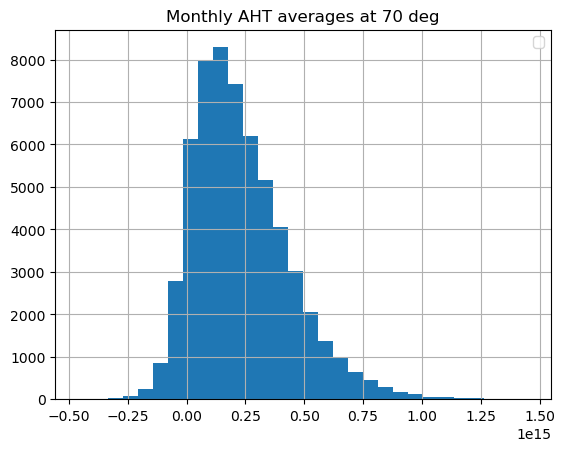

In [5]:
which_lat = 70
lat_idx = era_fncts.get_lat_idx(which_lat)

plt.hist(aht_ds.total_aht_moist.sel(latitude=which_lat).values.flatten() * geometry[lat_idx], bins=30)

plt.legend(loc=0)


plt.title('Monthly AHT averages at ' + str(which_lat) + ' deg')
plt.grid()

#plt.savefig('figures/lily_aht_plots/monthly_ave_aht_at_' + str(which_lat) + 'deg')
plt.show()

# Plot the time series of a single lat

In [8]:
aht_ds

<xarray.Dataset>
Dimensions:                     (time: 58440, latitude: 361)
Coordinates:
  * time                        (time) datetime64[ns] 1979-01-01 ... 2018-12-...
  * latitude                    (latitude) float64 90.0 89.5 ... -89.5 -90.0
Data variables: (12/18)
    total_aht                   (time, latitude) float64 ...
    eddy_aht                    (time, latitude) float64 ...
    mmc_aht                     (time, latitude) float64 ...
    total_aht_no_seasons        (time, latitude) float64 ...
    eddy_aht_no_seasons         (time, latitude) float64 ...
    mmc_aht_no_seasons          (time, latitude) float64 ...
    ...                          ...
    total_aht_dry               (time, latitude) float64 ...
    eddy_aht_dry                (time, latitude) float64 ...
    mmc_aht_dry                 (time, latitude) float64 ...
    total_aht_no_seasons_dry    (time, latitude) float64 ...
    eddy_aht_no_seasons_dry     (time, latitude) float64 ...
    mmc_aht_no_seasons_dry      (time, latitude) float64 ...

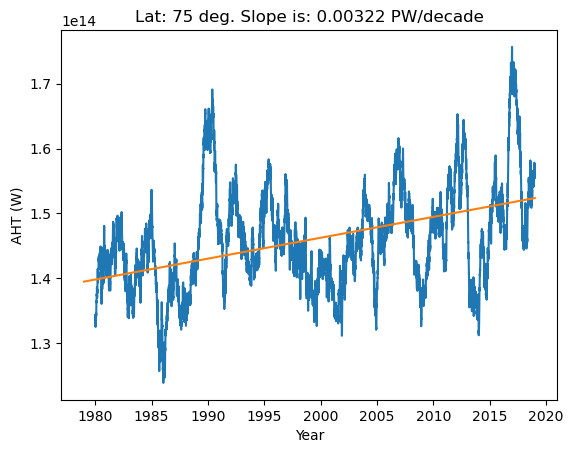

In [9]:
which_lat = 75
lat_idx = era_fncts.get_lat_idx(which_lat)
time_series = np.linspace(1979, 2019, 58440)

#which_field = eddy_all_times_no_season[:,lat_idx]
which_field = aht_ds.eddy_aht_moist[:,lat_idx] * geometry[lat_idx]

time_ave_length = 4*365

running_mean = np.convolve(which_field, np.ones(time_ave_length)/time_ave_length, mode='valid')

#plt.plot(time_series, which_field)

plt.plot(time_series[time_ave_length-1:], running_mean)

m, b = np.polyfit(time_series, which_field, 1)

plt.plot(time_series, m*time_series + b)
#plt.xlim([0, 10])
plt.xlabel('Year')
plt.ylabel('AHT (W)')
plt.title('Lat: ' + str(which_lat) + ' deg. Slope is: ' + str(round(10 * m/1e15, 5)) + ' PW/decade')

#plt.savefig('figures/lily_aht_plots/total_aht_moist_time_series_' + str(which_lat) + 'deg')

plt.show()

## See the seasonal cycle at all latitudes

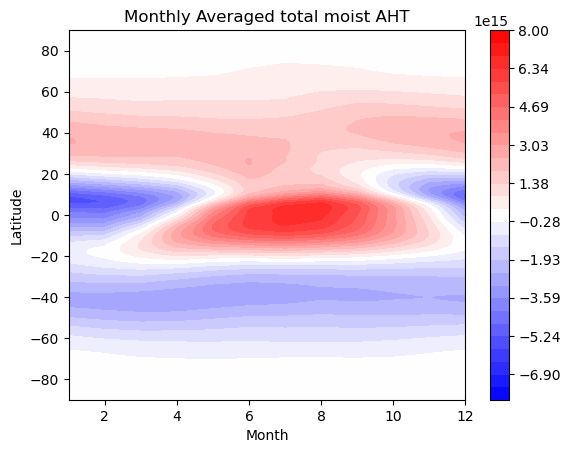

In [10]:
month_grouped = aht_ds.total_aht_moist.groupby('time.month').mean(['time'])

plt.contourf(range(1, 13), lats, (month_grouped*geometry[None,:]).T, levels=np.linspace(-8e15, 8e15, 30), cmap='bwr')

plt.colorbar()

plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('Monthly Averaged total moist AHT')

#plt.savefig('figures/lily_aht_plots/monthly_ave_total_aht_moist_all_lats')
plt.show()

## Monthly averages for one latitude

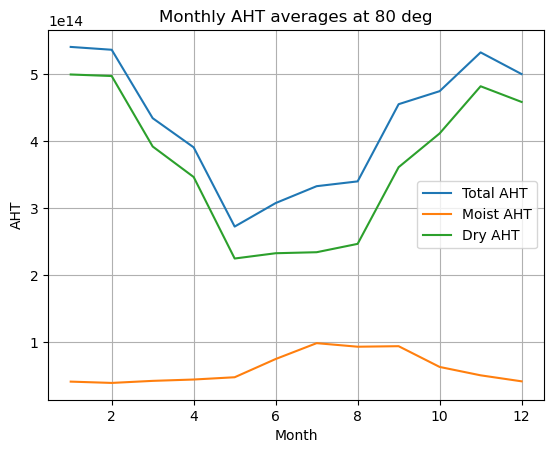

In [11]:
which_lat = 80
lat_idx = era_fncts.get_lat_idx(which_lat)

monthly_aves = aht_ds.groupby('time.month').mean(['time'])

plt.plot(range(1, 13), monthly_aves.total_aht[:,lat_idx] * geometry[lat_idx], label='Total AHT')
plt.plot(range(1, 13), monthly_aves.total_aht_moist[:,lat_idx] * geometry[lat_idx], label='Moist AHT')
plt.plot(range(1, 13), monthly_aves.total_aht_dry[:,lat_idx] * geometry[lat_idx], label='Dry AHT')

plt.legend(loc=0)

plt.xlabel('Month')
plt.ylabel('AHT')

plt.title('Monthly AHT averages at ' + str(which_lat) + ' deg')
plt.grid()

#plt.savefig('figures/lily_aht_plots/monthly_ave_aht_at_' + str(which_lat) + 'deg')
plt.show()

### Plot monthly trends at different latitudes and resample the data to do so

In [12]:
aht_ds_monthly = aht_ds.resample(time="1M").mean(['time'])

In [13]:
aht_ds_monthly

<xarray.Dataset>
Dimensions:                     (time: 480, latitude: 361)
Coordinates:
  * time                        (time) datetime64[ns] 1979-01-31 ... 2018-12-31
  * latitude                    (latitude) float64 90.0 89.5 ... -89.5 -90.0
Data variables: (12/18)
    total_aht                   (time, latitude) float64 605.9 ... 973.1
    eddy_aht                    (time, latitude) float64 0.0 5.661e+07 ... 0.0
    mmc_aht                     (time, latitude) float64 605.9 ... 973.1
    total_aht_no_seasons        (time, latitude) float64 1.285e+03 ... 1.063e+03
    eddy_aht_no_seasons         (time, latitude) float64 7.485e-12 ... -1.299...
    mmc_aht_no_seasons          (time, latitude) float64 1.285e+03 ... 1.063e+03
    ...                          ...
    total_aht_dry               (time, latitude) float64 0.0 5.404e+07 ... 0.0
    eddy_aht_dry                (time, latitude) float64 0.0 5.404e+07 ... 0.0
    mmc_aht_dry                 (time, latitude) float64 0.0 0.0 0.0 ... 0.0 0.0
    total_aht_no_seasons_dry    (time, latitude) float64 7.415e-12 ... -1.298...
    eddy_aht_no_seasons_dry     (time, latitude) float64 7.273e-12 ... -1.297...
    mmc_aht_no_seasons_dry      (time, latitude) float64 0.0 0.0 0.0 ... 0.0 0.0

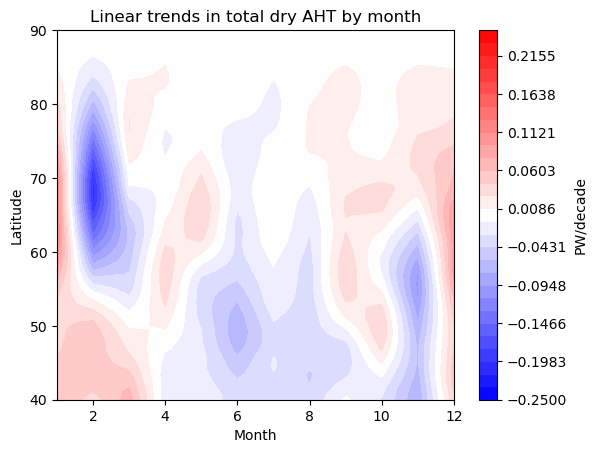

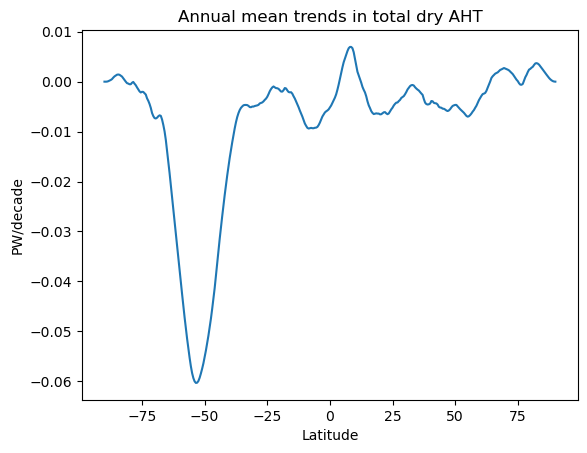

In [14]:

slopes = np.zeros((361, 12))

for i in range(361):
    lat_idx = i
    which_lat = lats[i]

    monthly_aves = aht_ds_monthly.total_aht_dry.sel(latitude = which_lat)

    for month in range(12):
        one_month_data = monthly_aves[month::12]
        m, b = np.polyfit(range(40), one_month_data * geometry[lat_idx], 1)
        slopes[i,month] = m
    
#plt.contourf(range(1, 13), lats, 10 * slopes/1e15, levels=np.linspace(-.08, .08, 30), cmap='bwr')
plt.contourf(range(1, 13), lats, 10 * slopes/1e15, levels=np.linspace(-.25, .25, 30), cmap='bwr')

plt.colorbar(label='PW/decade')

plt.ylim([40, 90])

plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('Linear trends in total dry AHT by month')

#plt.savefig('figures/lily_aht_plots/linear_total_dry_aht_trends_by_month_40_90N')
plt.show()

plt.plot(lats, 10*np.nanmean(slopes, axis=1)/1e15)
#plt.ylim([-.01, .01])
plt.xlabel('Latitude')

plt.ylabel('PW/decade')

plt.title('Annual mean trends in total dry AHT')
#plt.savefig('figures/lily_aht_plots/linear_total_dry_aht_trends_annual_mean')

plt.show()

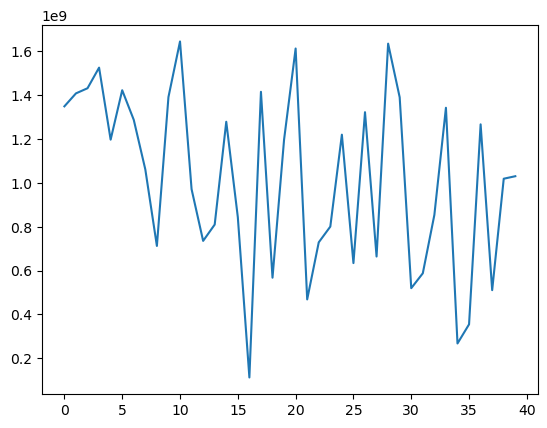

In [16]:
plt.plot(range(40), aht_ds_monthly.total_aht.sel(latitude=75)[1::12])

plt.show()